# Principal component analysis - does higher explained variance mean more predictive power? Part 2 - An empirical approach

### What's this about?
In principal component analysis (PCA), we select the PCs with the highest explained variance. As discussed in my previous [article](https://medium.com/digital-alchemist/principal-component-analysis-does-higher-explained-variance-mean-more-predictive-power-f59606ed1e7), I wonder when we use them for prediction, do they actually provide better predictive power?

This is an attempt to answer that question empirically. I have acquired 10 datasets from the [UCI Machine Learning Repository](#cite_1). After minimal cleaning, I will perform PCA on them and extract the 5 PCs with the highest explained variance in each of them as a group, and the next 5 PCs as another. 

For each of these datasets, I'll train an ensemble model with both the "top 5 PCs" group and the "next 5 PCs" group. Other groups of 5 random raw features (not PCs) will also be trained to provide comparison.

The cross validation scores of these groups will be compared to see if the top 5 PCs, with their higher explained variance, actually help the prediction score.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
from sklearn.preprocessing import StandardScaler
from pca_viz import do_PCA
from compare import compare_classification_features
from helpers import get_data, do_PCA, cross_validate_ensemble

In [17]:
RANDOM_STATE = 42
# fetch 10 datasets, split into features and targets, from a helper function
x_datas_original, y_datas = get_data()
# Number of observations and features in each dataset
print('(Number of observations, number of features) in each dataset:')
for x_data in x_datas_original:
    print(x_data.shape)

(Number of observations, number of features) in each dataset:
(6598, 166)
(287, 62)
(303, 57)
(4601, 57)
(1000, 59)
(208, 60)
(6118, 51)
(1567, 590)
(11500, 178)
(1848, 72)


In `get_data()` the data is minimally cleaned such that they can be fed into the pipeline without errors. I am not going to spend the time to clean the data thoroughly, check distributions and correlations, or select features. Because we are pitting groups of PCs extracted from the same data against one another, and we care only about the predictions. Anything that hurts the predictive power of one group of PCs is most likely to hurt another group about the same.

For the raw data and how the data is processed, check out my [github repo](https://github.com/alfrednfwong/PCA_predictive_power_study).

In [3]:
# standardize all the features
x_datas_std = []
for x_data in x_datas_original:
    x_datas_std.append(pd.DataFrame(StandardScaler().fit_transform(x_data)))

# generate groups of features for each dataset. 
# The first two groups come from PCA, with the first being the top 5 principal
# components (PCs) and the second the 6th to 10th PCs in terms of explained
# variance.
# The last 5 are groups of 5 randomly drawn columns from the dataset, without
# replacement. They will act as benchmarks for our reference.
x_datas_features_groups = []
explained_vars_top_5 = []
explained_vars_next_5 = []
for x_data in x_datas_std:
    # get the PCs
    _, pc_data, df_explained_var = do_PCA(
        10, x_data, random_state=RANDOM_STATE
    )
    pca_top_5 = pc_data.iloc[:, :5]
    pca_next_5 = pc_data.iloc[:, 5:10]
    # the index 1 because after the sum() it returns a single entry pd.Series,
    # with an index and a value. The index 1 is to extract the value.
    explained_vars_top_5.append(df_explained_var[:5].sum()[1])
    explained_vars_next_5.append(df_explained_var[5:10].sum()[1])

    # get random groups of 5 columns
    column_indices = np.array(range(len(x_data.columns)))
    np.random.shuffle(column_indices)
    rand_features_1 = x_data[column_indices[:5]]
    rand_features_2 = x_data[column_indices[5:10]]
    rand_features_3 = x_data[column_indices[10:15]]
    rand_features_4 = x_data[column_indices[15:20]]
    rand_features_5 = x_data[column_indices[20:25]]
    
    # This will be the various groups of features of one dataset (each group 
    # to be used in a model instance)
    feature_groups = [
        pca_top_5, pca_next_5, rand_features_1, rand_features_2, 
        rand_features_3, rand_features_4, rand_features_5
    ]
    # This will be the list containing data from all the datasets
    x_datas_features_groups.append(feature_groups)

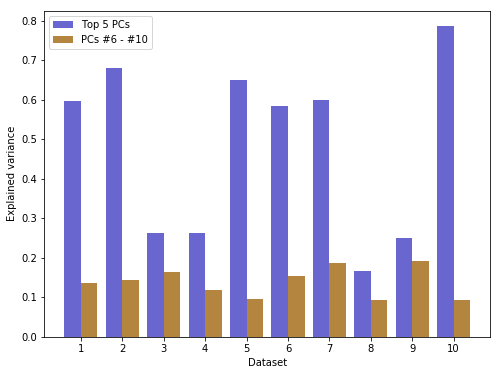

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
width = 0.4
ind = np.arange(1, 11)
bars1 = plt.bar(
    x=ind, height=explained_vars_top_5, width=width, color='#6966D0'
)
bars2 = plt.bar(
    x=ind + width, height=explained_vars_next_5, width=width, color='#B3853F'
)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(ind)
ax.set_ylabel('Explained variance')
ax.set_xlabel('Dataset')
ax.legend(['Top 5 PCs', 'PCs #6 - #10'])
plt.show()

The top 5 PCs have higher explained variance than the next 5 PCs, by different margins.

### The classifier model
Next we'll train an ensemble model on each of these groups of PCs and see which of them score higher in a 10 fold cross validation.
The ensemble model will be "council" of 4 different classifiers, and the output probability will be the mean of the probability each of them predicts.

The classifiers are:
1. Support vector machine with an rbf kernel (C=1000)
2. Random forest classifier
3. Logistic regression
4. K nearest neighbors (K=20)

I chose to use an ensemble so that if the effects of explained variance somehow only exhibit themselves in certain classifying algorithms, we'll be able to capture it. That is, of course, balanced by the consideration of computational time and the ability to give probability as an output (instead of just a class prediction). 

Most hyperparameters are arbitrary, as we can't have a set of to suit all 10 datasets anyway. Also, time spent on exploring the datasets and tuning the hyperparameters are probably better spent on acquiring more datasets -- the number of which I believe is sufficient as is.

In [5]:
# loop thru all datasets and all feature groups, feed each of them into the 
# model and put the cross validation score into a dataframe
warnings.filterwarnings('ignore')
df_r = pd.DataFrame()
# loop thru all the datasets
for i in (7, 9):
    feature_groups_scores = []
    #loop thru all the feature groups
    for j in range(7):
        _, test_score = cross_validate_ensemble(
            x_datas_features_groups[i][j], y_data=y_datas[i],
            num_folds=2, random_state=RANDOM_STATE
        )
        feature_groups_scores.append(test_score)
        print(f'Dataset {i}, feature group {j} done.')
    # the mean of the 3rd to 7th columns will be the mean score for the groups
    # of 5 random features
    rand_features_mean_score = np.mean(feature_groups_scores[2:7])
    df_r = df_r.append(
        [[*feature_groups_scores[0:2], rand_features_mean_score]]
    )

df_r.columns = ['top_5_PCs', 'next_5_PCs', 'rand_features_mean']
df_r = df_r.reset_index(drop=True)
df_r.index.name = 'dataset'
df_r.index += 1

Dataset 7, feature group 0 done.
Dataset 7, feature group 1 done.
Dataset 7, feature group 2 done.
Dataset 7, feature group 3 done.
Dataset 7, feature group 4 done.
Dataset 7, feature group 5 done.
Dataset 7, feature group 6 done.
Dataset 9, feature group 0 done.
Dataset 9, feature group 1 done.
Dataset 9, feature group 2 done.
Dataset 9, feature group 3 done.
Dataset 9, feature group 4 done.
Dataset 9, feature group 5 done.
Dataset 9, feature group 6 done.


In [6]:
df_r

,top_5_PCs,next_5_PCs,rand_features_mean
dataset,,,
1,0.500000,0.5,0.499795
2,0.509444,0.5,0.503889


0.1541376174598363
0.7526132404181185
0.7128712871287128
0.39404477287546186
0.365
0.46634615384615385
0.41745668519123896
0.06636885768985322
0.2
0.030844155844155844


In [8]:
df_r = pd.DataFrame(results)
df_r.index.name = 'dataset'
df_r.columns = [
    'top_5_PCs', 'next_5_PCs', 'rand_features_1', 
    'rand_features_2', 'rand_features_3', 
    'rand_features_4', 'rand_features_5'
]
df_r['rand_features_mean'] = df_r.iloc[:, 2:].mean(axis=1)
df_r = df_r[['top_5_PCs', 'next_5_PCs', 'rand_features_mean']]
df_r['top_5_wins'] = df_r.top_5_PCs > df_r.next_5_PCs
df_r

,top_5_PCs,next_5_PCs,rand_features_mean,top_5_wins
dataset,,,,
0,0.853547,0.813861,0.821055,True
1,0.588359,0.521433,0.572983,True
2,0.815305,0.635354,0.563708,True
3,0.919686,0.838280,0.761303,True
4,0.803115,0.702904,0.751783,True
5,0.846878,0.663673,0.733381,True
6,0.815900,0.797683,0.781451,True
7,0.500000,0.500000,0.499931,False
8,0.919262,0.858752,0.865837,True


The model on datasets 8 and 10 has barely any predictive power. After getting the results I've checked and found that the target variables in them are very unbalanced and that was part of the cause. I haven't done anything to balance output classes and in the ensemble. But if I do now, say by class-balanced resampling, after I've seen the results, I might be doing something similar to p-hacking. I decide to leave it as is.

In [16]:
print('Proportion of values 1 in targets of dataset...')
for i in range(10):
    print(f'{i + 1}: {sum(y_datas[i] / len(y_datas[i]))}')

Proportion of values 1 in targets of dataset...
1: 0.1541376174598373
2: 0.7526132404181183
3: 0.7128712871287147
4: 0.39404477287545214
5: 0.36500000000000027
6: 0.4663461538461533
7: 0.41745668519122553
8: 0.06636885768985307
9: 0.1999999999999985
10: 0.030844155844155827


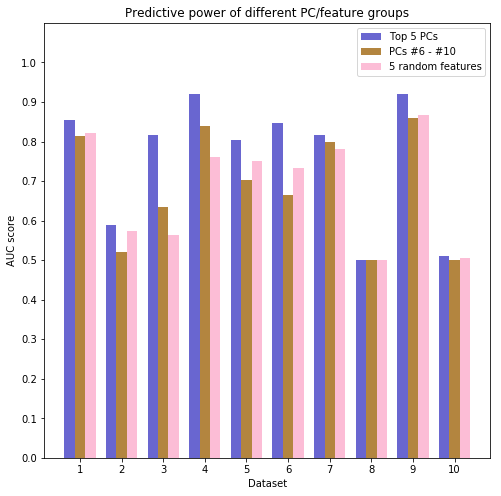

In [31]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
width = 0.25
ind = np.arange(1, 11)
bars1 = plt.bar(
    x=ind - width, height=df_r.top_5_PCs, width=width, color='#6966D0'
)
bars2 = plt.bar(
    x=ind, height=df_r.next_5_PCs, width=width, color='#B3853F'
)
bars3 = plt.bar(
    x=ind + width, height=df_r.rand_features_mean, width=width, color='#FCBDD6'
)
ax.set_xticks(ind)
ax.set_xticklabels(ind)
ax.set_ylabel('AUC score')
ax.set_xlabel('Dataset')
ax.set_title('Predictive power of different PC/feature groups')
ax.legend(['Top 5 PCs', 'PCs #6 - #10', '5 random features'], loc=1)
ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.show()

### Results
So it looks like higher explained variance does come with more predictive power. In all but one of our datasets, the 5 principal components with the highest explained variance outperform the next 5 principal components. They also outperform the groups of 5 random features.

Here for each dataset, the 5 random features are generated by taking 5 groups of 5 random raw features (ie, before PCA). Each group is trained in the model and the cross validation score is computed, and then the mean score for all the groups will be the score for "5 random features" for that dataset.

The probability of X >= 9 if X follows a binomial distribution Bin(10, 0.5) is 0.0107. That means in the following **imaginary** case:
1. the datasets I collected were representative of all datasets in the world, and,
2. the problems associated with these datasets are reprensentative of all machine learning problems in the world, and,
3. the classification algorithms and hyperparameters are representative of all algorithms and hyperparameters in the world,

we could say that at alpha level 0.05, we reject H0: Explained variance in a principal component is unrelated to predictive power, in favor of H1: Higher explained variance does come with higher predictive power. And we missed alpha level 0.01 by just a hair.

### Conclusion
This problem had been bugging me since the first day I learnt PCA. None of my instructors, mentors, knowledgeable friends and the almighty google could give me a proof as to why picking the top PCs means retaining the most predictive power in the features. Some say it's just another thing for you to try and see if the test scores come out better, others say it's empirical, yet none offered any evidence, mathematical or empirical.

From what we've seen I think we can say with some certainty that choosing to maximize explained variance in PCA helps in prediction studies. 

Of course, that is not to say my findings are definitive. This study has many limitations, such as:
1. limited number and diversity of datasets,
2. only binary classification problems are studied,
3. only a handful of classification algorithms are used. Deep learning, in particular, is not included.

But at least, this study puts the inquisitive me to rest, for now.

For the code please check out my [github repo](https://github.com/alfrednfwong/PCA_predictive_power_study).

### Data sources

All the datasets are obtained from the UCI Machine Learning Repository:

<a id='cite_1'></a>Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Dataset 1: [The Musk (Version 2) Dataset](https://archive.ics.uci.edu/ml/datasets/Musk+%28Version+2%29)

Dataset 2: [Quality Assessment of Digital Colposcopies Data Set](https://archive.ics.uci.edu/ml/datasets/Quality+Assessment+of+Digital+Colposcopies). 


Dataset 3: [Z-Alizadeh Sani Data Set](https://archive.ics.uci.edu/ml/datasets/Z-Alizadeh+Sani).

Dataset 4: [Spambase Data Set](https://archive.ics.uci.edu/ml/datasets/Spambase)

Dataset 5: [Sports articles for objectivity analysis Data Set](https://archive.ics.uci.edu/ml/datasets/Sports+articles+for+objectivity+analysis).

Dataset 6: [Connectionist Bench (Sonar, Mines vs. Rocks) Data Set](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29)

Dataset 7: [First-order theorem proving Data Set](https://archive.ics.uci.edu/ml/datasets/First-order+theorem+proving)

Dataset 8: [SECOM Data Set](https://archive.ics.uci.edu/ml/datasets/SECOM)

Dataset 9: [Epileptic Seizure Recognition Data Set](https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition), also available [here](http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3)

Dataset 10: [Ozone Level Detection Data Set](https://archive.ics.uci.edu/ml/datasets/Ozone+Level+Detection)

